<a href="https://colab.research.google.com/github/AstroNoodles/Mini-Projects/blob/master/Parallel_Sync_CNN_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel Synchronous Gradient Descent CNN Research
In this notebook, I am led by graduate student Pengzhan Guo to create a synchronous CNN that can be parallelized between multiple supercomputers and is optimized by the best gradient descent networks (ADAM or RMSProp).

The CNN will be trained using the CiFAR dataset which will predict images out of 10 classes and multiple trials of the experiment will be done.

https://github.com/geifmany/cifar-vgg/blob/master/cifar10vgg.py

In [0]:
# To run Keras on any GPUs on the computer, this line must be included
# !pip3 install tensorflow-gpu

In [2]:
# Obtain the imports for the project
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, GlobalAveragePooling2D 
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

NUM_CLASSES = 10
EPOCHS = 400
BATCH_SIZE = 128


Using TensorFlow backend.


# Preprocessing the dataset
This is the step where visualization and preprocessing is done in the CIFAR10 dataset that Keras gives us.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"The shape of the training data is {x_train.shape} and the shape of the labels are {y_train.shape}")

170500096/170498071 [==============================] - 2s 0us/step
The shape of the training data is (50000, 32, 32, 3) and the shape of the labels are (50000, 1)


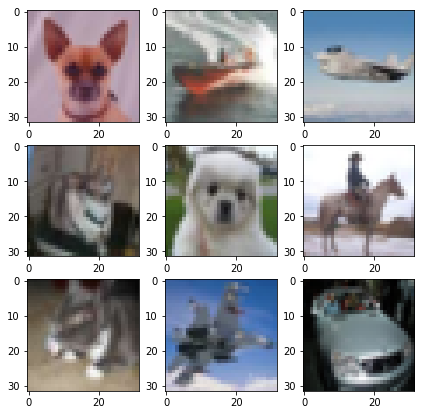

In [4]:
def visualize_cifar(train_data):
  """ Visualizes the cifar-10 dataset using matplotlib. This helps give a greater understanding
      of the items that are in the dataset"""
  plt.figure(figsize=(7, 7))
  for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(random.choice(train_data))

visualize_cifar(x_train)


In [0]:
def normalize_data(x_train, x_test):
  mean_train, mean_test = np.mean(x_train), np.mean(x_test)
  std_train, std_test = np.std(x_train), np.std(x_test)
  return ((x_train - mean_train) / std_train, (x_test - mean_test) / std_test)
  

In [0]:
def smooth_label(labels, epsillion):
  """ Adds a smooth labeling to all the one-hot encoded labels to prevent overfitting
      in the dataset: https://tinyurl.com/kerastricks"""
  if 0 <= epsillion <= 1:
    labels *= (1.0 - epsillion)
    labels += (epsillion / labels.shape[1])
  else:
    raise Exception("Label smoothing factor should be between 0 and 1. Your factor is: " + str(epsillion))
  
  return labels
  

In [7]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

x_train, x_test = normalize_data(x_train, x_test)

y_train = keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

smooth_label(y_train, 0.1)
print(y_train[0])

# Preprocessing the image dataset by artificially increasing the training data size
# via rescaling, shifting, flipping and rotating the dataset.
data_gen = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=True,
    rotation_range=90, 
    width_shift_range=.2, 
    height_shift_range=.2, 
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.0, 1.0),
    rescale=2)

data_gen.fit(x_train)

[0.01       0.01       0.01       0.01       0.01       0.01
 0.90999997 0.01       0.01       0.01      ]


# Building The Model
The model was built by using a combination of methods from the Inceptionv3 model and the VGGNet models that are on Github. The layers used are given in the imports in the first code cell.

In [0]:
def create_conv_net():
  model = Sequential()
  
  # Layer 1
  model.add(Conv2D(32, (3, 1), kernel_initializer="he_normal", input_shape=(32, 32, 3), 
                   padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (1, 3), padding="same", kernel_regularizer=l2()))  
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D(2, 2))
            
  # Layer 2
  model.add(Conv2D(64, (3, 1), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (1, 3), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(.3))          
            
  # Layer 3
  model.add(Conv2D(128, (3, 1), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (1, 3), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D(2, 2))
            
  # Layer 4
  model.add(Conv2D(256, (3, 1), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(256, (1, 3), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2, 2))
   
 
  # Layer 5
  model.add(Conv2D(512, (3, 1), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(512, (1, 3), padding="same", kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  model.add(MaxPooling2D(2, 2))
  model.add(Dropout(.5)) 
  
            
  # Layer 6 
  model.add(Flatten())
  model.add(Dense(512, kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  
  # Layer 7
  model.add(Dense(512, kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
            
  # Layer 8 
  model.add(Dense(256, kernel_regularizer=l2()))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(.5))
            
  # Layer 9
  # model.add(GlobalAveragePooling2D())
  model.add(Dense(NUM_CLASSES))
  model.add(Activation('softmax'))
  
  return model
           

In [15]:
model = create_conv_net()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
activation_35 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 32)        3104      
_________________________________________________________________
activation_36 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
__________

# Executing the Model
Now, the model built above will be executed with the training set. If there are more than one GPUs on the computer this file is being called in, then it will parallelize the model between the GPUs, else it will execute on the one GPU and CPU. 

In [0]:
# First, check the available amount of parallel GPUs
from keras import backend as K
gpus = K.tensorflow_backend._get_available_gpus()
print(f'Available GPUs on this device are: {gpus}')

isParallel = len(gpus) > 1

Available GPUs on this device are: ['/job:localhost/replica:0/task:0/device:GPU:0']


In [0]:
# Now, run the model.
optimizer = SGD(momentum=0.9, nesterov = True)
# optimizer = Adam(epsilon=1e-8)

if isParallel:
  print('GPUs parallelized!')
  multi_gpu_model = keras.utils.multi_gpu_model(model, len(gpus))
  multi_gpu_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
  multi_gpu_model.fit_generator(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE), epochs=EPOCHS,
                      validation_data=(x_test, y_test))
else:
  print('CPU Compilation')
  
  model.compile(optimizer=optimizer, loss="categorical_crossentropy", 
                metrics=['accuracy'])
  model.fit_generator(data_gen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                      steps_per_epoch=(x_train.shape[0] // BATCH_SIZE), epochs=EPOCHS,
                      validation_data=(x_test, y_test))

W0805 15:52:57.712718 140715371923328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



CPU Compilation


W0805 15:52:57.945425 140715371923328 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/400
390/390 [==============================] - 39s 101ms/step - loss: 11.2318 - acc: 0.1884 - val_loss: 6.1220 - val_acc: 0.1000
Epoch 2/400
390/390 [==============================] - 34s 87ms/step - loss: 3.9953 - acc: 0.2541 - val_loss: 3.1629 - val_acc: 0.1223
Epoch 3/400
390/390 [==============================] - 34s 87ms/step - loss: 2.5085 - acc: 0.2827 - val_loss: 2.7268 - val_acc: 0.1000
Epoch 4/400
390/390 [==============================] - 34s 86ms/step - loss: 2.1998 - acc: 0.3005 - val_loss: 2.4783 - val_acc: 0.1369
Epoch 5/400
390/390 [==============================] - 34s 87ms/step - loss: 2.1192 - acc: 0.3238 - val_loss: 2.3388 - val_acc: 0.1650
Epoch 6/400
390/390 [==============================] - 34s 87ms/step - loss: 2.1085 - acc: 0.3265 - val_loss: 2.5225 - val_acc: 0.1253
Epoch 7/400
390/390 [==============================] - 34s 87ms/step - loss: 2.0935 - acc: 0.3336 - val_loss: 2.4142 - val_acc: 0.2090
Epoch 8/400
390/390 [==============================] 